In [2]:
#Librairies
import time
import torch
import torchvision

#Raccourcis utilisé
import torch.nn as nn
from torchvision.transforms.functional import crop

from PIL import Image
from IPython.display import display

import pandas as pd

In [3]:
#Téléchargement de la datasets
mnist_dataset = torchvision.datasets.MNIST(".", train=True, download=True)

In [4]:
display(mnist_dataset[128][0])

In [5]:
#Labels pour chacune des images
labels = [x[1] for x in mnist_dataset]

for x in range(10):
  print("Number of", x, ":", labels.count(x))

Number of 0 : 5923
Number of 1 : 6742
Number of 2 : 5958
Number of 3 : 6131
Number of 4 : 5842
Number of 5 : 5421
Number of 6 : 5918
Number of 7 : 6265
Number of 8 : 5851
Number of 9 : 5949


In [6]:
#test d'un découpage d'une image
X = mnist_dataset[2][0].resize((30,30))
#on redimensionne l'image en 30x30 pour ne pas perdre de donnée par rapport à un découpage en 3x9x28(27x28)
zones = {}
zones[0] = X.crop((0,0,30,10))
zones[1] = X.crop((0,10,30,20))
zones[2] = X.crop((0,20,30,30))

In [7]:
display(zones[0])
display(zones[1])
display(zones[2])

On ne donne pas au réseau de neurone le type de spline via calculs par point de controle et 
minimisation de la distance à ceux-ci qu'il doit reconnaitre.
Mais plutot, en fonction de la partie de l'image (haut, milieu et bas), 
on indique au réseau qu'il doit trouver un certain nombre de spline différente 
(exemple: 10 pour la partie du haut).

Le choix de ce nombre est très important pour éviter le sous ou le sur-apprentissage du réseau.
 J'ai choisi ses chiffres en prenant compte les 10 chiffres et leurs differentes écritures,
 mais aussi la similitude entre plusieur chiffres sur certaine partie
(exemple:la partie du bas des 0,6,8 sont similaires, il est donc inutile de faire apprendre 
3 patterns différents de spline au réseau)

In [8]:
class APP(nn.Module): # Classe APPrentissage

  def __init__(self,nb_splines=(8,10,8),threshold=0.1):
    super(APP, self).__init__()
    
    ## on remplit les images de zéros
    self.padding = nn.ZeroPad2d((0,0,1,1))
    
    ## Première convolution
    self.conv0 = nn.Sequential()
    self.conv1 = nn.Sequential()
    self.conv2 = nn.Sequential()
    self.conv = {0:self.conv0,1:self.conv1,2:self.conv2}
    self.fc0 = nn.Sequential()
    self.fc1 = nn.Sequential()
    self.fc2 = nn.Sequential()
    self.fc = {0:self.fc0,1:self.fc1,2:self.fc2}
    
    for i in range(3):
        self.conv[i].add_module("conv_1", nn.Conv2d(in_channels = 1, out_channels= 6 , kernel_size = 5))
        self.conv[i].add_module("relu_1", nn.ReLU())
        
        self.conv[i].add_module("conv_2", nn.Conv2d(in_channels = 6, out_channels= 12 , kernel_size = 5))
        self.conv[i].add_module("max_pool_2", nn.MaxPool2d(2))
        self.conv[i].add_module("relu_2", nn.ReLU())

        self.fc[i].add_module("fc_3", nn.Linear(in_features = 120, out_features = 64))
        self.fc[i].add_module("relu_3", nn.ReLU())
        self.fc[i].add_module("dropout_3", nn.Dropout())
        
        self.fc[i].add_module("fc_4", nn.Linear(in_features = 64, out_features = nb_splines[i]))
        #self.fc[i].add_module("relu_4", nn.ReLU())
        self.fc[i].add_module("thresold_4", nn.Threshold(threshold=threshold, value=0))
        
    
    
    self.output = nn.Linear(sum(nb_splines), 10)
    
    self.softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, x):

    x = self.padding(x)

    zones = {}
    zones[0] = x[:,:,:10,:]
    zones[1] = x[:,:,10:20,:]
    zones[2] = x[:,:,20:30,:]
    
    
    for i in range(3):
        zones[i] = self.conv[i](zones[i])
        zones[i] = zones[i].view(-1, 12*1*10)
        zones[i] = self.fc[i](zones[i])
        
        '''
        #print(zones[i].shape)
        max_zones = torch.max(zones[i],dim=0)
        #print(max_zones)
        
        one = torch.ones(zones[i].shape)
        zero = torch.zeros(zones[i].shape)
        if zones[i].is_cuda:
            one, zero = one.cuda(), zero.cuda()
        #print(zones[i],zones[i].is_cuda,max_zones,one,zero)
        zones[i] = torch.where(zones[i]==max_zones.values,one,zero)
        '''
        
    
    x = torch.cat((zones[0],zones[1],zones[2]),1)
    
    x = self.output(x)
    y = self.softmax(x)
    
    return y, zones

In [9]:
## Création d'une instance pour notre réseau
net = APP()

##  Convertion des images PIL au format tensor
convert = torchvision.transforms.ToTensor()

## En entrée on a alors une image tensor que le dimention en "unsqueeze" 
## car PyTorch est habitué à travailler avec des batchs.
x = convert(mnist_dataset[0][0]).unsqueeze(0)

## Application du réseau sur les entrées
y=net(x)
y

(tensor([[-2.5032, -2.4038, -2.1930, -2.3471, -2.3133, -2.2871, -2.2658, -2.2058,
          -2.1658, -2.3911]], grad_fn=<LogSoftmaxBackward>),
 {0: tensor([[0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<ThresholdBackward0>),
  1: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.1257]], grad_fn=<ThresholdBackward0>),
  2: tensor([[0.1267, 0.0000, 0.0000, 0.1297, 0.0000, 0.0000, 0.0000, 0.0000]],
         grad_fn=<ThresholdBackward0>)})

In [10]:
## Chargement du Dataset
mnist_dataset = torchvision.datasets.MNIST(".", train=True, transform=convert, download=True)

## Pourcentage de validation sur le dataset
validation_split = 0.1

N_val_samples = round(validation_split * len(mnist_dataset))

## Division en 2 sous-ensemble
train_set, val_set = torch.utils.data.random_split(mnist_dataset, [len(mnist_dataset) - N_val_samples, N_val_samples])

# train et val sont des objets de ces sous-ensemble
print(train_set)
print(val_set)

# On vérifie leur taille
len(train_set) + len(val_set) == len(mnist_dataset)

True

In [11]:
##Création un DataLoader à partir de notre ensemble de formation mnist
BATCH_SIZE = 64

mnist_train_dl = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
mnist_val_dl = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [12]:
batch = torch.Tensor(next(iter(mnist_train_dl))[0])

batch = batch.cuda()

In [13]:
net = APP()

## Déplacement du réseau sur le GPU
net = net.cuda()
y=net(batch)

In [14]:
net

APP(
  (padding): ZeroPad2d(padding=(0, 0, 1, 1), value=0.0)
  (conv0): Sequential(
    (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu_1): ReLU()
    (conv_2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
    (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (conv1): Sequential(
    (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu_1): ReLU()
    (conv_2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
    (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (conv2): Sequential(
    (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu_1): ReLU()
    (conv_2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
    (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (fc0): Sequential(
    (fc_3): Linear(in_features=120, out_features=64, bias

In [15]:
##RE-RUN du CODE pour obtenir un nouveau réseau

LEARNING_RATE = 0.003
MOMENTUM = 0.9

nb_splines = (8,10,8)

net = APP(nb_splines,threshold=0.1)

net = net.cuda()

criterion = nn.NLLLoss()

# Méthode stochastique de descente du grandient 
optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [16]:
## Nombre d'époque d'apprentissage
N_EPOCHS = 20

epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []
start_time = time.time()

for e in range(N_EPOCHS):
  
    print("EPOCH:",e)

    ### boucle d'entraineement
    running_loss = 0
    running_accuracy = 0
    start_epoch_time=time.time()

    ## Le réseau est mis en mode "entrainement"
    net.train()

    for i, batch in enumerate(mnist_train_dl):
    
        # Obtenir batch du dataloader
        x = batch[0]
        labels = batch[1]

        # déplacer le batch sur le GPU
        x = x.cuda()
        labels = labels.cuda()

        # Calcul de l'output et les loss
        output = net(x)
        y = output[0]
        
        #a = output[0]
        #b = output[1]
        
        #print('a',a)
        #print('b',b)
        '''
        print(len(output))
        print('output0')        
        print(len(output[0]))   
        print('output1')  
        print(len(output[1]) )        
        
        print('lab et y')             
        print(labels)
        print(y)
        print('yshapa et ashape')  
        print(y.shape)
        print(a.shape)        
        print('b')  
        print(b)        
        '''
        
        loss = criterion(y, labels)

        # Réinitialisation du gradients
        optimizer.zero_grad()

        # Calculs du gradients
        loss.backward()

        # Appliquecation d'une étape d'optimisation de l'algorithme de descente pour mettre à jour les poids
        optimizer.step()

        with torch.no_grad():
            running_loss += loss.item()
            running_accuracy += (y.max(1)[1] == labels).sum().item()
    
    print("Training accuracy:", running_accuracy/float(len(train_set)),
        "Training loss:", running_loss/float(len(train_set)))

    epoch_loss.append(running_loss/len(train_set))
    epoch_acc.append(running_accuracy/len(train_set))

    ### Boucle de valisation
    ## Le réseau est mis en mode validation
    net.eval()

    running_val_loss = 0
    running_val_accuracy = 0

    for i, batch in enumerate(mnist_val_dl):
    
        with torch.no_grad():
            
            x = batch[0]
            labels = batch[1]

            
            x = x.cuda()
            labels = labels.cuda()

            
            output = net(x)
            y = output[0]

            
            loss = criterion(y, labels)

            running_val_loss += loss.item()
            running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    
    print("Validation accuracy:", running_val_accuracy/float(len(val_set)),
        "Validation loss:", running_val_loss/float(len(val_set)))

    epoch_val_loss.append(running_val_loss/len(val_set))
    epoch_val_acc.append(running_val_accuracy/len(val_set))
    
    inter = time.time() - start_epoch_time  
    print ('Temps de l Epoch ',e,' en secondes:', inter )
    
    
interval = time.time() - start_time  
print ('Temps total en secondes:', interval )


EPOCH: 0
Training accuracy: 0.11527777777777778 Training loss: 0.03596894676155514
Validation accuracy: 0.11466666666666667 Validation loss: 0.03584646892547608
Temps de l Epoch  0  en secondes: 15.526580095291138
EPOCH: 1
Training accuracy: 0.4034259259259259 Training loss: 0.025712035840308223
Validation accuracy: 0.7348333333333333 Validation loss: 0.012452734231948853
Temps de l Epoch  1  en secondes: 15.647926092147827
EPOCH: 2
Training accuracy: 0.7457037037037038 Training loss: 0.01177963374555111
Validation accuracy: 0.8571666666666666 Validation loss: 0.007177814697225888
Temps de l Epoch  2  en secondes: 15.994412183761597
EPOCH: 3
Training accuracy: 0.8277962962962963 Training loss: 0.008212943829871991
Validation accuracy: 0.8908333333333334 Validation loss: 0.00537551395346721
Temps de l Epoch  3  en secondes: 15.834852457046509
EPOCH: 4
Training accuracy: 0.8590740740740741 Training loss: 0.006847647134904508
Validation accuracy: 0.9001666666666667 Validation loss: 0.0046

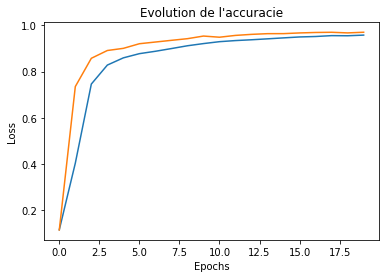

In [17]:
import matplotlib.pyplot as plt
import numpy as np


plt.plot(np.arange(0,N_EPOCHS),epoch_acc)
plt.plot(np.arange(0,N_EPOCHS),epoch_val_acc)
plt.title("Evolution de l'accuracie")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [18]:
def Pattern (j) :
    
    ## Chargement du Dataset
    mnist_dataset = torchvision.datasets.MNIST(".", train=False, transform=convert, download=True)

    # for label 1
    idx = mnist_dataset.targets== j
    mnist_dataset.targets = mnist_dataset.targets[idx]
    mnist_dataset.data = mnist_dataset.data[idx]

    ##Création un DataLoader à partir de notre ensemble de formation mnist
    BATCH_SIZE = 64

    mnist_dl = torch.utils.data.DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    stats = {}

    for i in range(3):
        stats[i] = pd.DataFrame(columns = range(nb_splines[i]))

    running_loss = 0
    running_accuracy = 0

    for i, batch in enumerate(mnist_dl):

        with torch.no_grad():

            x = batch[0]
            labels = batch[1]


            x = x.cuda()
            labels = labels.cuda()


            output = net(x)
            y = output[0]

            for i in range(3):
                stats[i] = stats[i].append(pd.DataFrame(output[1][i].cpu().detach().numpy()))

            loss = criterion(y, labels)

            running_loss += loss.item()
            running_accuracy += (y.max(1)[1] == labels).sum().item()

    print("Pondération des pattern sur le chiffre",j)
    print ("pondération des pattern sur la partie du haut")
    print (stats[0].mean(0))
    print (stats[0].var(0))
    print ("pondération des pattern sur la partie du milieu")
    print (stats[1].mean(0))
    print (stats[1].var(0)) 
    print ("pondération des pattern sur la partie du bas")
    print (stats[2].mean(0))
    print (stats[2].var(0))

In [19]:
Pattern(0)

Pondération des pattern sur le chiffre 0
pondération des pattern sur la partie du haut
0    0.000000
1    1.558559
2    0.193810
3    1.269274
4    5.846822
5    0.000000
6    0.000369
7    0.958418
dtype: float32
0     0.000000
1     0.587444
2     0.035751
3     0.458457
4    11.261260
5     0.000000
6     0.000046
7     0.222812
dtype: float32
pondération des pattern sur la partie du milieu
0     4.076822
1     4.527554
2    14.558720
3     0.014678
4     0.513954
5     0.000000
6     9.969784
7     7.626714
8     1.506464
9     0.005608
dtype: float32
0     2.685180
1     4.651746
2    16.056345
3     0.022123
4     0.216130
5     0.000000
6     9.060729
7     4.034804
8     0.783666
9     0.006076
dtype: float32
pondération des pattern sur la partie du bas
0    3.112203
1    1.642631
2    3.706434
3    3.478654
4    0.489955
5    8.297876
6    0.001073
7    0.120516
dtype: float32
0    2.098625
1    1.052017
2    2.686880
3    1.130613
4    0.086139
5    1.797193
6    0.000210
7  

In [20]:
Pattern(8)


Pondération des pattern sur le chiffre 8
pondération des pattern sur la partie du haut
0    0.000000
1    1.694248
2    0.197222
3    1.327592
4    6.586351
5    0.000000
6    0.000000
7    1.001869
dtype: float32
0    0.000000
1    0.660960
2    0.026470
3    0.528074
4    9.702019
5    0.000000
6    0.000000
7    0.257733
dtype: float32
pondération des pattern sur la partie du milieu
0    2.179589
1    4.770841
2    2.973438
3    5.721763
4    0.319371
5    0.001537
6    1.351931
7    1.550240
8    5.109433
9    0.328460
dtype: float32
0    1.199432
1    3.008913
2    1.726792
3    3.222981
4    0.124095
5    0.000332
6    2.293673
7    1.044956
8    2.504807
9    0.633775
dtype: float32
pondération des pattern sur la partie du bas
0    2.548473
1    1.485188
2    3.832792
3    2.317526
4    0.509724
5    5.976085
6    0.031364
7    0.697300
dtype: float32
0    1.855478
1    1.530115
2    1.605121
3    1.300442
4    0.070827
5    3.365507
6    0.012391
7    0.548350
dtype: float32


In [21]:
Pattern(6)

Pondération des pattern sur le chiffre 6
pondération des pattern sur la partie du haut
0    0.000000
1    0.286075
2    0.165373
3    0.059262
4    0.475200
5    0.000000
6    0.001365
7    0.040333
dtype: float32
0    0.000000
1    0.035497
2    0.012115
3    0.029703
4    1.144724
5    0.000000
6    0.000164
7    0.017186
dtype: float32
pondération des pattern sur la partie du milieu
0    2.726392
1    6.742618
2    2.715136
3    3.695428
4    0.216184
5    0.000000
6    7.616370
7    1.249306
8    0.768765
9    0.088918
dtype: float32
0    0.957569
1    5.081152
2    5.340383
3    2.445670
4    0.121027
5    0.000000
6    6.459066
7    1.260778
8    0.898188
9    0.165519
dtype: float32
pondération des pattern sur la partie du bas
0    0.945285
1    2.616600
2    0.685087
3    2.075886
4    0.319927
5    7.315616
6    0.000144
7    0.071071
dtype: float32
0    0.309562
1    1.490183
2    0.729852
3    0.660033
4    0.084086
5    1.935132
6    0.000020
7    0.048323
dtype: float32


In [22]:
Pattern(4)

Pondération des pattern sur le chiffre 4
pondération des pattern sur la partie du haut
0    0.000000
1    0.377017
2    0.029473
3    0.192340
4    0.177426
5    0.000000
6    0.033873
7    0.061985
dtype: float32
0    0.000000
1    0.020050
2    0.004947
3    0.020337
4    0.350697
5    0.000000
6    0.004373
7    0.013237
dtype: float32
pondération des pattern sur la partie du milieu
0    3.036037
1    8.256270
2    5.206063
3    4.036694
4    0.130699
5    0.000616
6    6.950453
7    5.264729
8    8.349197
9    0.137045
dtype: float32
0     2.095969
1     6.790784
2     5.788703
3     4.841733
4     0.095843
5     0.000186
6     7.756901
7     3.588429
8    12.702686
9     0.357892
dtype: float32
pondération des pattern sur la partie du bas
0    0.607575
1    1.114339
2    0.222569
3    0.515953
4    0.163163
5    0.517304
6    0.063445
7    1.652442
dtype: float32
0    0.235491
1    0.754433
2    0.135193
3    0.676818
4    0.030475
5    0.738243
6    0.013917
7    0.553310
dtype: 

In [23]:
Pattern(7)

Pondération des pattern sur le chiffre 7
pondération des pattern sur la partie du haut
0    0.000000
1    1.530467
2    0.160828
3    1.097672
4    6.241327
5    0.000000
6    0.000000
7    0.855911
dtype: float32
0     0.000000
1     0.657160
2     0.019368
3     0.449582
4    11.067670
5     0.000000
6     0.000000
7     0.223313
dtype: float32
pondération des pattern sur la partie du milieu
0     6.669556
1     0.893621
2     5.182264
3     2.745365
4     0.434480
5     0.273200
6     1.553117
7    10.495654
8     5.364809
9     4.990507
dtype: float32
0    8.576561
1    2.632853
2    6.390982
3    4.337922
4    0.220255
5    0.120401
6    6.254930
7    9.385838
8    3.950173
9    9.140628
dtype: float32
pondération des pattern sur la partie du bas
0    1.918962
1    0.187314
2    0.576634
3    0.641568
4    0.080574
5    0.161726
6    0.330547
7    2.807218
dtype: float32
0    0.913058
1    0.209450
2    0.664175
3    0.772507
4    0.017849
5    0.304975
6    0.045886
7    0.642114